In [1]:
#Import required modules
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import glob as glob

In [2]:
#load in whole dataset

EC_Earth3_dir = '/g/data/e14/sm2435/CMIP6/EC-Earth3/'
#load in all full DS to get climatology
U=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'UO/*.nc' ))
V=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'VO/*.nc' ))
W=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'WO/*.nc' ))
T=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'THETAO/*.nc' ))

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future defaul

In [3]:
#define function to calcualte Anomlay and climatology 
def get_clim(DS):
    #calc climatology
    clim = DS.groupby('time.month').mean('time')
    ANOM = DS.groupby('time.month') - clim
    return ANOM, clim

In [4]:
#restrict data down to 9 gridcell block
U = U.sel(lat=slice(7,10),lon=slice(57,60))
V = V.sel(lat=slice(7,10),lon=slice(57,60))
W = W.sel(lat=slice(7,10),lon=slice(57,60))
T = T.sel(lat=slice(7,10),lon=slice(57,60))
#get W coords in same type as others
W = W.assign_coords(lev = T.lev)

In [5]:
#now get anomaly and climatology terms for each variable
ua, ubar = get_clim(U.uo)
va, vbar = get_clim(V.vo)
wa, wbar = get_clim(W.wo)
ta, tbar = get_clim(T.thetao)

In [6]:
#need to rechunk 'ta' array so that it can be differentiated. then calc deriviatives 
dTdt = T.thetao.chunk(1980, 20,3,3).differentiate(coord = 'time',datetime_unit= 's')
dTdx = ta.differentiate('lon') / (110e3 * np.cos(ta.lat * np.pi / 180))
dTdy = ta.differentiate('lat') / 110e3 
dTdz = ta.differentiate('lev')
#climatological values
dTbardx = tbar.differentiate('lon') / (110e3 * np.cos(tbar.lat * np.pi / 180))
dTbardy = tbar.differentiate('lat') / 110e3
dTbardz = tbar.differentiate('lev')

In [7]:
#now get U advection terms, need to ensure data is coreectly goruped to add together
udTdx = ua*dTdx
ubardTdx = ubar*dTdx.groupby('time.month')
udtbardx = ua.groupby('time.month')*dTbardx
#get v
vdTdy = va*dTdy
vbardTdy = vbar*dTdy.groupby('time.month')
vdtbardy = va.groupby('time.month')*dTbardy
#get w
wdTdz = wa*dTdz
wbardTdz = wbar*dTdz.groupby('time.month')
wdtbardz = wa.groupby('time.month')*dTbardz

In [8]:
#now extract central point of each of these terms
udTdx = udTdx[:,:,1,1]
ubardTdx = ubardTdx[:,:,1,1]
udtbardx = udtbardx[:,:,1,1]
#get v
vdTdy = vdTdy[:,:,1,1]
vbardTdy = vbardTdy[:,:,1,1]
vdtbardy = vdtbardy[:,:,1,1]
#get w
wdTdz = wdTdz[:,:,1,1]
wbardTdz = wbardTdz[:,:,1,1]
wdtbardz = wdtbardz[:,:,1,1]
#
dTdt = dTdt[:,:,1,1]

In [9]:
#now integrate through levels to get 2d timeseries at point
udTdx_i = udTdx.integrate('lev')
ubardTdx_i = ubardTdx.integrate('lev')
udtbardx_i = udtbardx.integrate('lev')

vdTdy_i = vdTdy.integrate('lev')
vbardTdy_i = vbardTdy.integrate('lev')
vdtbardy_i = vdtbardy.integrate('lev')

wdTdz_i = wdTdz.integrate('lev')
wbardTdz_i = wbardTdz.integrate('lev')
wdtbardz_i = wdtbardz.integrate('lev')

dTdt_i = dTdt.integrate('lev')

In [10]:
#load in q and get qnet
Q = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/EC-Earth3_HFDS.nc')
#get qnet and subset
qpch = (Q.hfds/(3986*1026*61.11283875)).sel(lat=slice(7,10),lon=slice(57,60))[:,1,1]

In [11]:
uadv = udtbardx_i+udTdx_i+ubardTdx_i
vadv = vdtbardy_i+vdTdy_i+vbardTdy_i
wadv = wdtbardz_i+wdTdz_i+wbardTdz_i

In [12]:
#now load required vars to memory
dTdt_i.load()
uadv.load()
vadv.load()
wadv.load()
qpch.load()

<xarray.DataArray 'hfds' (time: 1980)>
array([-6.0867887e-07, -4.2403877e-07,  1.4638105e-07, ...,
        2.2577427e-07, -2.7054609e-08, -3.7295746e-07], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    lon      float64 58.5
    lat      float64 8.5

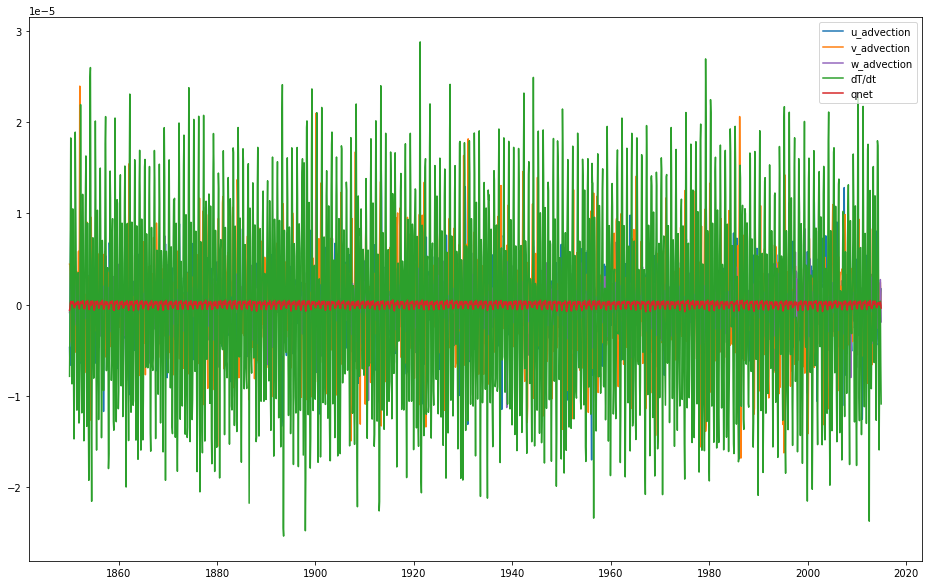

In [13]:
#now make test plot for first 2 years data
plt.figure(figsize = (16,10))
plt.plot(uadv.time, uadv, c = 'tab:blue', label = 'u_advection')
plt.plot(vadv.time, vadv, c = 'tab:orange', label = 'v_advection')
plt.plot(wadv.time, wadv, c = 'tab:purple', label = 'w_advection')

plt.plot(dTdt_i.time, dTdt_i, c = 'tab:green', label = 'dT/dt')
plt.plot(qpch.time, qpch, c = 'tab:red', label = 'qnet')
plt.legend()

In [14]:
#get monthly budgets of each term
dTdt_i_M = dTdt_i.groupby('time.month').mean('time')
qpch_M = qpch.groupby('time.month').mean('time')
uadv_M = uadv.groupby('time.month').mean('time')
vadv_M = vadv.groupby('time.month').mean('time')
wadv_M = wadv.groupby('time.month').mean('time')
qpch_M = qpch.groupby('time.month').mean('time')

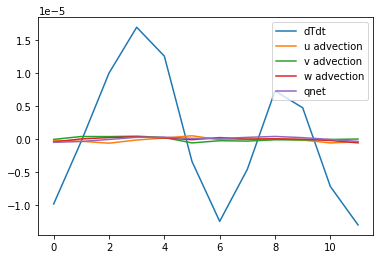

In [15]:
#plot monthly budget of each term
plt.figure()
plt.plot(dTdt_i_M, label = 'dTdt')
#plt.plot(uadv_M+vadv_M+wadv_M, label = 'advcetion')
plt.plot(uadv_M, label = 'u advection')
plt.plot(vadv_M, label = 'v advection')
plt.plot(wadv_M, label = 'w advection')
plt.plot(qpch_M, label = 'qnet')
#plt.plot(resid_M, label = 'residual')
plt.legend()

In [16]:
resid = dTdt_i +uadv+vadv+wadv-qpch
resid_M = resid.groupby('time.month').mean('time')

In [17]:
for i in T.time:
    dTdt = (T[i+2]-T[i])/(2*60*60*24*30)

TypeError: iteration over a 0-d array

In [18]:
T=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'THETAO/*.nc' ))

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [19]:
T = T.thetao.sel(lat=slice(7,10),lon=slice(57,60)).mean(['lat', 'lon'])

In [20]:
try:
    for i in range(len(T)):
            dTdt1 = ((T[i+2]-T[i])/(2*60*60*24*30))
except:
    print('error')

error


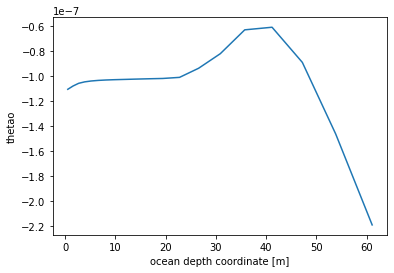

In [21]:
dTdt1.plot()

In [22]:
data_list = []
try:
    for i in range(len(T)):
        dtval = ((T[i+2]-T[i])/(2*60*60*24*30)).values
        data_list.append(dtval)
except:
    print('error')

error


In [23]:
DTarr = np.asarray(data_list)

In [30]:
dTdt_test = xr.DataArray(DTarr, coords={'time': T.time[1:-1], 'lev': T.lev},
             dims=['time', 'lev'], attrs=dict(

        description="dT/dt, calculated with central differecning (t3-t1/2months)",

        units="degC per second"))

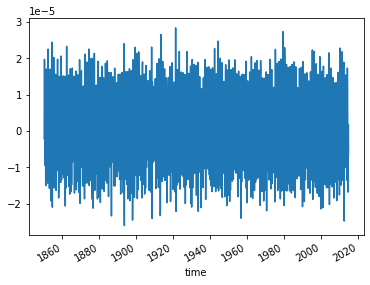

In [33]:
dTdt_test.integrate('lev').plot()

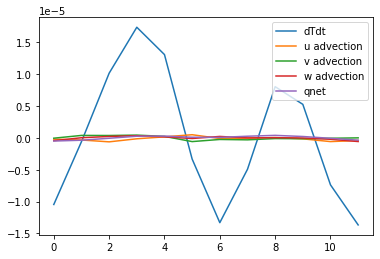

In [35]:
#plot monthly budget of each term
plt.figure()
plt.plot(dTdt_test.integrate('lev').groupby('time.month').mean('time'), label = 'dTdt')
#plt.plot(uadv_M+vadv_M+wadv_M, label = 'advcetion')
plt.plot(uadv_M, label = 'u advection')
plt.plot(vadv_M, label = 'v advection')
plt.plot(wadv_M, label = 'w advection')
plt.plot(qpch_M, label = 'qnet')
#plt.plot(resid_M, label = 'residual')
plt.legend()

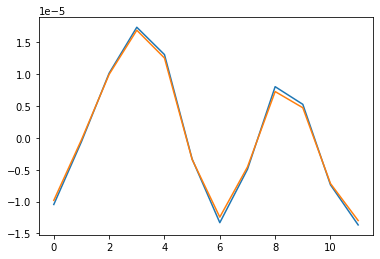

In [36]:
plt.figure()
plt.plot(dTdt_test.integrate('lev').groupby('time.month').mean('time'), label = 'dTdt')
plt.plot(dTdt_i_M, label = 'dTdt')


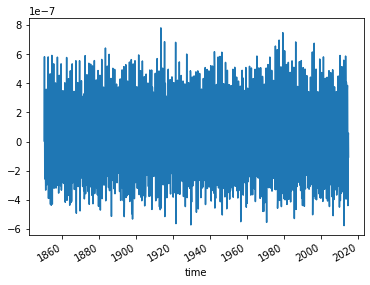

In [56]:
(((dTdt_test.lev[0]*dTdt_test[:,0])+(dTdt_test.lev[1]*dTdt_test[:,1]))/(2*(dTdt_test.lev[1]-dTdt_test.lev[0]))).plot()

In [60]:
data_list = []
try:
    for i in range(len(T)):
        dtval = (((dTdt_test.lev[i]*dTdt_test[:,i])+(dTdt_test.lev[i+1]*dTdt_test[:,i+1]))/
                 (2*(dTdt_test.lev[i+1]-dTdt_test.lev[i]))).values 
        data_list.append(dtval)
except:
    print('error')
    
DTarr = np.asarray(data_list)    

    

error


In [74]:
int_test = xr.DataArray(DTarr, coords={'lev': T.lev[0:-1], 'time': T.time[1:-1]},
             dims=['lev', 'time'], attrs=dict(

        description="dT/dt, calculated with central differecning (t3-t1/2months)",

        units="degC per second"))

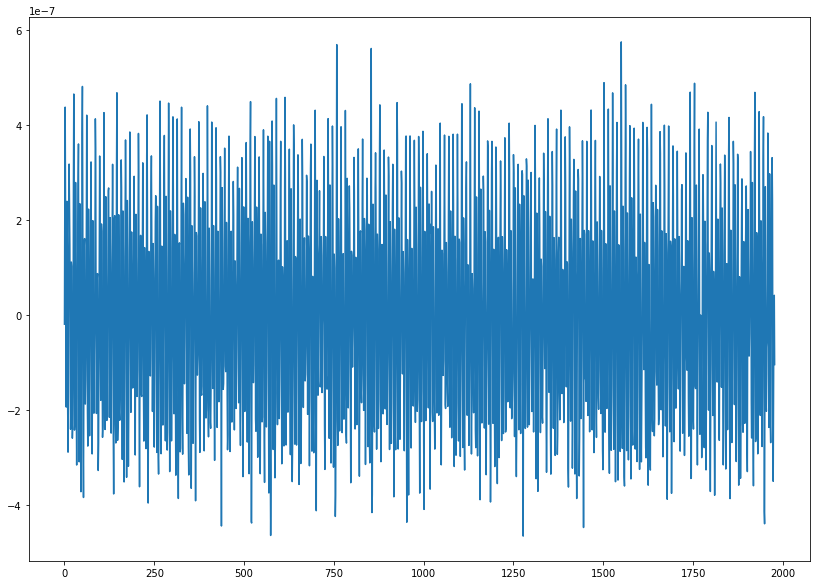

In [85]:
plt.figure(figsize = (14,10))
#plt.plot(int_test.mean('lev'), label = 'dTdt')
plt.plot(dTdt_test.mean('lev'), label = 'dTdt')

#plt.plot(dTdt_i_M, label = 'dTdt')


In [89]:
weights = dTdt_test.lev.values

In [91]:
weights = np.insert(weights, 0,0)

In [92]:
weights

array([ 0.        ,  0.50576001,  1.55585527,  2.66768169,  3.85627985,
        5.14036131,  6.5430336 ,  8.09251881,  9.82275009, 11.77367973,
       13.99103832, 16.52532196, 19.42980194, 22.75761604, 26.55830002,
       30.87456131, 35.74020386, 41.18002319, 47.21189499, 53.85063553,
       61.11283875])

In [115]:
W2 = weights[2:]-weights[1:-1]
#W3 = xr.DataArray(W2, coords={'lev': T.lev},
#             dims=['lev'])

In [103]:
WdTdt=dTdt_test.weighted(W3).mean('lev')

In [116]:
W2


array([1.05009526, 1.11182642, 1.18859816, 1.28408146, 1.40267229,
       1.54948521, 1.73023129, 1.95092964, 2.21735859, 2.53428364,
       2.90447998, 3.3278141 , 3.80068398, 4.31626129, 4.86564255,
       5.43981934, 6.0318718 , 6.63874054, 7.26220322])

In [117]:
W3

<xarray.DataArray (lev: 20)>
array([0.50576001, 1.05009526, 1.11182642, 1.18859816, 1.28408146,
       1.40267229, 1.54948521, 1.73023129, 1.95092964, 2.21735859,
       2.53428364, 2.90447998, 3.3278141 , 3.80068398, 4.31626129,
       4.86564255, 5.43981934, 6.0318718 , 6.63874054, 7.26220322])
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85 61.11

In [119]:
sum(weights)/weights[-1]

6.859281370143962